In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, LSTM
from tensorflow.keras.models import Model,load_model

In [15]:
name_lst = list(map(lambda x: x[7:-4], glob.glob(r"./data/*.csv")))
print(name_lst)
data = pd.read_csv('./data/SamsungE_onehot2.csv', index_col = 0)
data.head()

['LGE', 'LGE_onehot', 'LGE_onehot2', 'NAVER', 'NAVER_onehot', 'NAVER_onehot2', 'SamsungBL', 'SamsungBL_onehot', 'SamsungBL_onehot2', 'SamsungE', 'SamsungEU', 'SamsungEU_onehot', 'SamsungEU_onehot2', 'SamsungE_onehot', 'SamsungE_onehot2', 'SKH', 'SKH_onehot', 'SKH_onehot2']


,weekdate,SamsungE_RU,SamsungE_U,SamsungE_UC,SamsungE_D,SamsungE_RD,SamsungE_end,SamsungE_start,SamsungE_high,SamsungE_low,SamsungE_abount
date,,,,,,,,,,,
17/01/02,0,1805000,0,0,1,0,0,1799000,1812000,1794000,93012
17/01/03,1,1824000,0,1,0,0,0,1814000,1831000,1801000,147153
17/01/04,2,1808000,0,0,1,0,0,1825000,1826000,1805000,159435
17/01/05,3,1778000,0,0,0,1,0,1803000,1803000,1777000,219349
17/01/06,4,1810000,0,1,0,0,0,1809000,1822000,1802000,177619


In [14]:
def moving_window(data,sequence_num,step):
    X_train = []
    for i in range(0,len(data)-sequence_num,step):
        X_train.append(data[i:i+sequence_num])
    
    X_train = np.array(X_train)
    return X_train

train = moving_window(data,30,1)

def normalization(train):
    for t in train:
        t[:,0] = t[:,0]/4
        p_max = t[:,8].max(axis = 0)
        p_min = t[:,9].min(axis = 0)
        a_max = t[:,10].max(axis = 0)
        t[:,1] = (t[:,1] - p_min)/(p_max-p_min)
        t[:,7] = (t[:,7] - p_min)/(p_max-p_min)
        t[:,8] = (t[:,8] - p_min)/(p_max-p_min)
        t[:,9] = (t[:,9] - p_min)/(p_max-p_min)
        t[:,10] = t[:,10]/a_max

normalization(train)
df = pd.DataFrame(train[0])
df.head()

,0,1,2,3,4,5,6,7,8,9,10
0,0,0,0,0,1,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,0
4,1,0,0,1,0,0,0,0,0,0,0


In [28]:
LReLU = tf.keras.layers.LeakyReLU()

X = Input(shape=[29,11])
H = LSTM(16,activation = 'tanh', return_sequences = True)(X)
H = LSTM(32,activation = 'tanh', return_sequences = True)(H)
H = LSTM(16,activation = 'tanh', return_sequences = True)(H)
H = LSTM(8,activation = 'tanh', return_sequences = True)(H)
H = LSTM(5,activation = 'softmax', return_sequences = False)(H)
Y = tf.keras.layers.Reshape((1,5))(H)
model = Model(X, Y)


cross = tf.keras.losses.CategoricalCrossentropy(
    from_logits=False, label_smoothing=0, reduction="auto", name="categorical_crossentropy")

adam = tf.keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(optimizer=adam,loss=cross)
model.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 29, 11)]          0         
_________________________________________________________________
lstm_30 (LSTM)               (None, 29, 16)            1792      
_________________________________________________________________
lstm_31 (LSTM)               (None, 29, 32)            6272      
_________________________________________________________________
lstm_32 (LSTM)               (None, 29, 16)            3136      
_________________________________________________________________
lstm_33 (LSTM)               (None, 29, 8)             800       
_________________________________________________________________
lstm_34 (LSTM)               (None, 5)                 280       
_________________________________________________________________
reshape_4 (Reshape)          (None, 1, 5)              0   

In [29]:
adam = tf.keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(optimizer=adam,loss=cross)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 20, restore_best_weights = True)
#callbacks=[early_stopping]
history = model.fit(train[:,0:29],train[:,29:30,[2,3,4,5,6]],epochs = 100,batch_size = 20,validation_split = 0.05)

Epoch 1/100
57/57 [==============================] - 11s 56ms/step - loss: 1.5976 - val_loss: 1.5484
Epoch 2/100
57/57 [==============================] - 2s 28ms/step - loss: 1.5368 - val_loss: 1.4539
Epoch 3/100
57/57 [==============================] - 2s 27ms/step - loss: 1.4606 - val_loss: 1.3874
Epoch 4/100
57/57 [==============================] - 2s 28ms/step - loss: 1.4129 - val_loss: 1.3532
Epoch 5/100
57/57 [==============================] - 2s 28ms/step - loss: 1.3736 - val_loss: 1.3232
Epoch 6/100
57/57 [==============================] - 2s 28ms/step - loss: 1.3796 - val_loss: 1.3009
Epoch 7/100
57/57 [==============================] - 2s 27ms/step - loss: 1.3396 - val_loss: 1.2847
Epoch 8/100
57/57 [==============================] - 2s 27ms/step - loss: 1.3425 - val_loss: 1.2697
Epoch 9/100
57/57 [==============================] - 2s 27ms/step - loss: 1.3285 - val_loss: 1.2554
Epoch 10/100
57/57 [==============================] - 2s 28ms/step - loss: 1.3100 - val_loss: 1.245

57/57 [==============================] - 2s 27ms/step - loss: 1.2247 - val_loss: 1.1679
Epoch 83/100
57/57 [==============================] - 2s 27ms/step - loss: 1.2418 - val_loss: 1.1729
Epoch 84/100
57/57 [==============================] - 2s 27ms/step - loss: 1.2291 - val_loss: 1.1780
Epoch 85/100
57/57 [==============================] - 2s 27ms/step - loss: 1.2067 - val_loss: 1.1790
Epoch 86/100
57/57 [==============================] - 2s 30ms/step - loss: 1.2285 - val_loss: 1.1685
Epoch 87/100
57/57 [==============================] - 1s 26ms/step - loss: 1.2524 - val_loss: 1.1720
Epoch 88/100
57/57 [==============================] - 1s 25ms/step - loss: 1.2181 - val_loss: 1.1831
Epoch 89/100
57/57 [==============================] - 1s 26ms/step - loss: 1.2250 - val_loss: 1.1943
Epoch 90/100
57/57 [==============================] - 1s 26ms/step - loss: 1.2153 - val_loss: 1.1715
Epoch 91/100
57/57 [==============================] - 1s 25ms/step - loss: 1.2199 - val_loss: 1.1772
Epo

In [30]:
adam = tf.keras.optimizers.Adam(lr=0.00001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(optimizer=adam,loss=cross)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 20, restore_best_weights = True)

history = model.fit(train[:,0:29],train[:,29:30,[2,3,4,5,6]],epochs = 500,callbacks=[early_stopping], batch_size = 20,validation_split = 0.05)

Epoch 1/500
57/57 [==============================] - 12s 65ms/step - loss: 1.2434 - val_loss: 1.1703
Epoch 2/500
57/57 [==============================] - 2s 28ms/step - loss: 1.2238 - val_loss: 1.1736
Epoch 3/500
57/57 [==============================] - 2s 28ms/step - loss: 1.2370 - val_loss: 1.1760
Epoch 4/500
57/57 [==============================] - 2s 28ms/step - loss: 1.2369 - val_loss: 1.1767
Epoch 5/500
57/57 [==============================] - 2s 28ms/step - loss: 1.2073 - val_loss: 1.1780
Epoch 6/500
57/57 [==============================] - 2s 28ms/step - loss: 1.2240 - val_loss: 1.1791
Epoch 7/500
57/57 [==============================] - 2s 28ms/step - loss: 1.2528 - val_loss: 1.1784
Epoch 8/500
57/57 [==============================] - 1s 26ms/step - loss: 1.2217 - val_loss: 1.1786
Epoch 9/500
57/57 [==============================] - 1s 26ms/step - loss: 1.2464 - val_loss: 1.1789
Epoch 10/500
57/57 [==============================] - 1s 26ms/step - loss: 1.2225 - val_loss: 1.180

In [33]:
Y = model.predict(train[:,0:29])
np.where(Y>0.5)

(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))

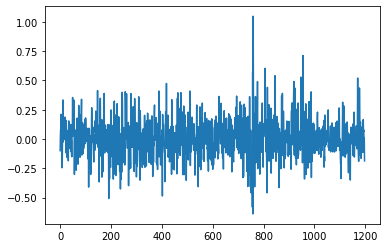

In [11]:
print(train[:10,29:30,2:7])

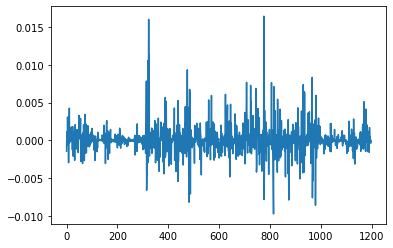

In [14]:
ev = train[:,29:30,2]*Y
plt.plot(ev)
plt.show()

In [16]:
len(np.where(ev > 0)[0])

602